In [1]:
#Usual suspects
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, Optional

# Add path to our library
import sys
sys.path.insert(1,'../muograph/')

# Import get_hits_from_csv from utils.py
from utils.utils import get_hits_from_csv
hits = get_hits_from_csv('../data/DataCu.csv')

# Import the tracking classclass
from tracking.tracking import Tracking

# Run tracking for only n events
n = 10000
tracks = Tracking(hits=hits[:,:,:n])

Tracking in progress...


Tracking completed!


# <center> **Tutorial 2: POCA reconstruction algorithm**
**POCA** stands for Point Of Closest Approach and is a very simple and completely geometric **algorithm** used for muon scattering tomography **image reconstruction**. It is based on the following **approximations**:

 - Muons are assumed to **scatter once** in the passive material
 - The **interaction point** is assumed to be at the **closest point between** the **incoming** and **outgoing tracks**.
 
These assumptions poorly describe the true muon path since the latter undergo multiple throughout the all path within the material, as shown on the figure below:
 
<img src="../images/POCA_sketch.png">

Based on these approximations, the **POCA point** is defined as the **closest point between the incoming and outgoing muon tracks**. In 2D, the POCA point is simply the interestction between two straigh lines (if non-parallels). In 3D, two straight lines do not intersect and the POCA point is **located** at the **center** of the **shortest segment connecting the two lines** (which is also perpendicular to both lines). 

<img src="../images/POCA_point_geometry_sketch.png">

But because the **POCA point** of 2 **parallel lines** is **not defined**, we need to get rid of such events before proceeding to POCA calculation. If two tracks are parallel, their scattering is close to zero. Thus, scattering angle can be used as a discriminator.

## <center> **Exercice 1: parallel tracks rejection**

As explained above, we must remove the events with parallel tracks. It can be done in 2 steps:
    
 - 1 - Create a mask for parallel events rejection (a.k.a an array of bolleans, see example below). If you are completely knew to masking, you can have a look at this [tutorial](https://www.youtube.com/watch?v=sjIzRpVXd30).
 - 2 - Apply the mask to our data (a.k.a the instance of the `Tracking` class)
    
***N.B**: You might want to use the scattering angle*`dtheta` *as a discriminator. In order to find the appropriate value of the `dtheta` discriminator, you might want to plot the `dtheta` histogram*.

[False  True  True  True  True False False False False False]
x before masking =  [0 1 2 3 4 5 6 7 8 9]
x after masking =  [1 2 3 4]


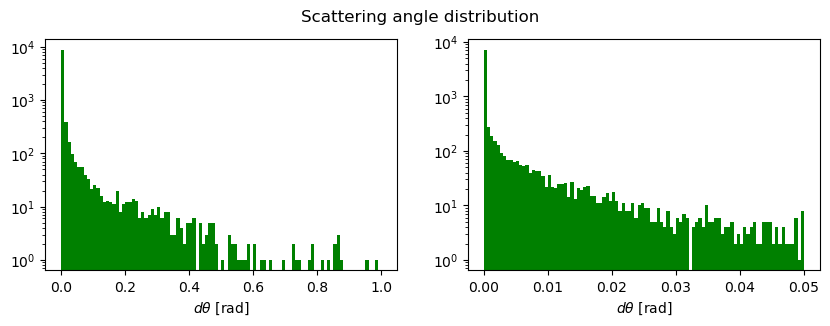

In [2]:
# Example

# Some data
x = np.array([0,1,2,3,4,5,6,7,8,9])

# Mask 
mask = (x>0) & (x<5)
print(mask)
print("x before masking = ",x)
print("x after masking = ", x[mask])

def plot_scatering_angles(tracks:Tracking, ranges:Tuple[float] = (1.,0.05), mask = None) -> None:

    '''
    Plots the scattering angle distribution. If a mask is provided, plots the masked scattering angle distribution.
    '''
    if(mask is None):
        mask = np.ones_like(tracks.dtheta,dtype=bool)
    else:
        print("\nmask rejected {} events".format(len(mask)-mask.astype(int).sum()))
    
    # Plotting dtheta
    fig,ax = plt.subplots(ncols=2,figsize=(10,3))
    fig.suptitle("Scattering angle distribution")
    # from 0 - 1 rad
    ax[0].hist(tracks.dtheta[mask],bins=100, range=(0,ranges[0]),log=True,color="green")
    ax[0].hist(tracks.dtheta[mask==False],bins=100, range=(0,ranges[0]),log=True,color="red",label="rejected events")
    
    ax[0].set_xlabel(r'$d\theta$ [rad]')
    # from 0 - .05 rad
    ax[1].hist(tracks.dtheta[mask],bins=100, range=(0,ranges[1]),log=True,color='green')
    ax[1].hist(tracks.dtheta[mask==False],bins=100, range=(0,ranges[1]),log=True,color='red',label="rejected events")
    ax[1].set_xlabel(r'$d\theta$ [rad]')

    if(mask.sum()!=len(mask)):
        ax[0].legend()
        ax[1].legend()
        
    plt.show()


plot_scatering_angles(tracks)

#### **1 - Create a masking function**

Create your masking function in the cell below. Then **compute how many events** are **rejected** by the mask. It will give us an idea of the signal/background ratio order of magnitude.

In [3]:
def compute_parallel_tracks_mask(tracks:Tracking, dtheta_cut:float=0.001) -> np.ndarray:
    
    '''
    Create a mask based on a scattering angle.
    
    INPUT:
     - dtheta_cut:float, the cut on scattering angle
     - tracks:Tracking, an instance of the Tracking class
    
    OUTPUT:
     - mask:np.ndarray, a boolean mask with size (tracks.n_event)
    '''
    
    mask = tracks.dtheta > dtheta_cut
    
    return mask

# parralel events =  7399
# non parralel events =  2601

mask rejected 7399 events


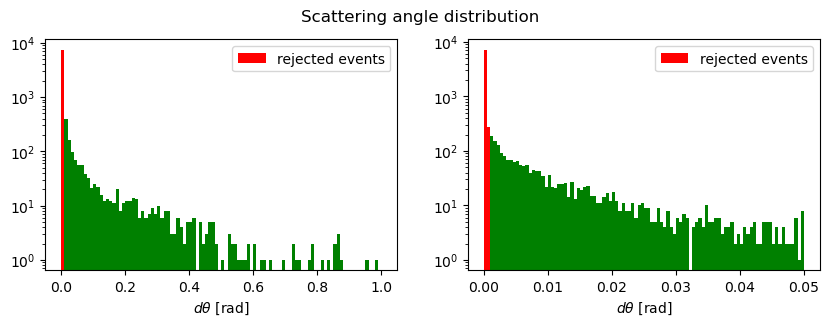

In [4]:
# test your masking function here
parallel_mask = compute_parallel_tracks_mask(tracks)


# compute number of rejected events
n_rejected_events = (parallel_mask==False).sum()
print("# parralel events = ", n_rejected_events)
print("# non parralel events = ", len(parallel_mask)-n_rejected_events)

#plot scattering angle distribution
plot_scatering_angles(tracks=tracks,mask=parallel_mask)

#### **2 - Apply the mask**

The `Tracking` class has a method called `apply_mask()` which can be used to remove all events `i` for which `mask[i]==False`. Call it with your mask as an input.

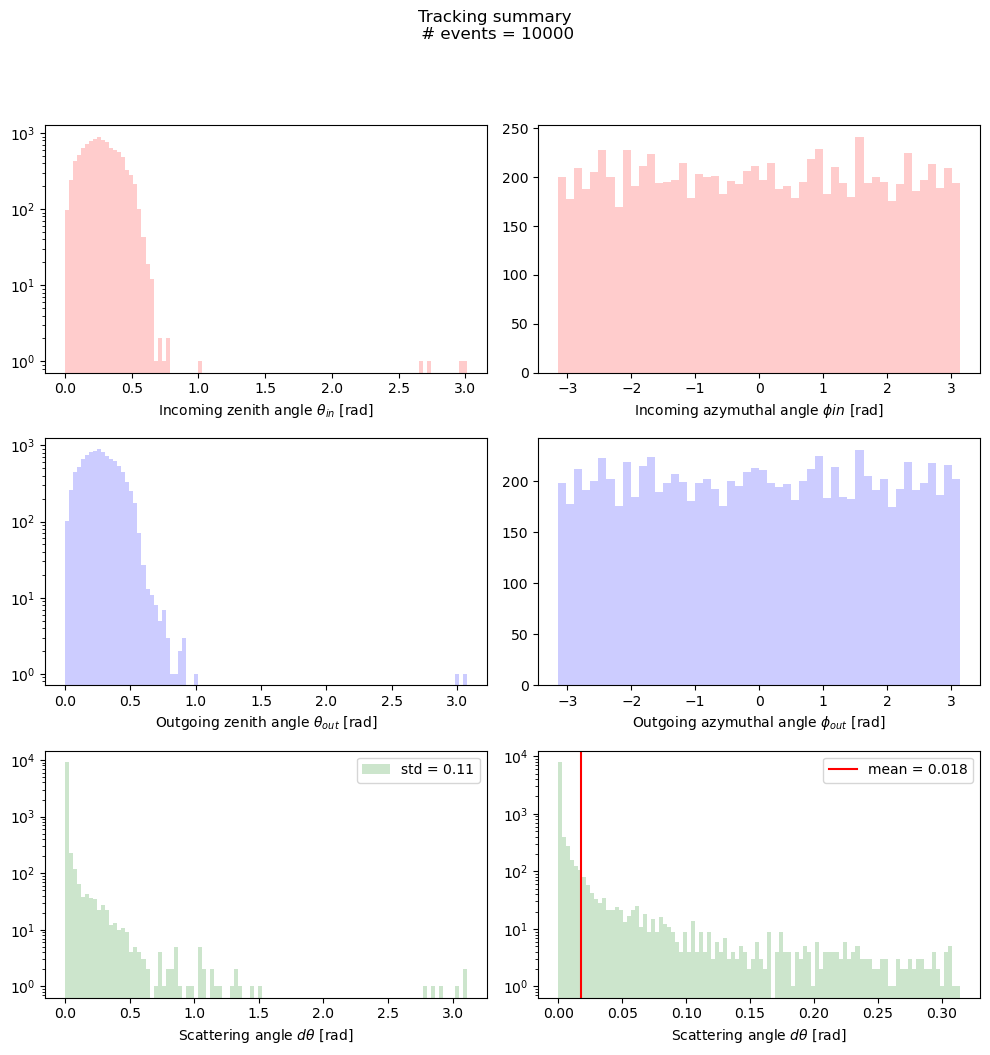

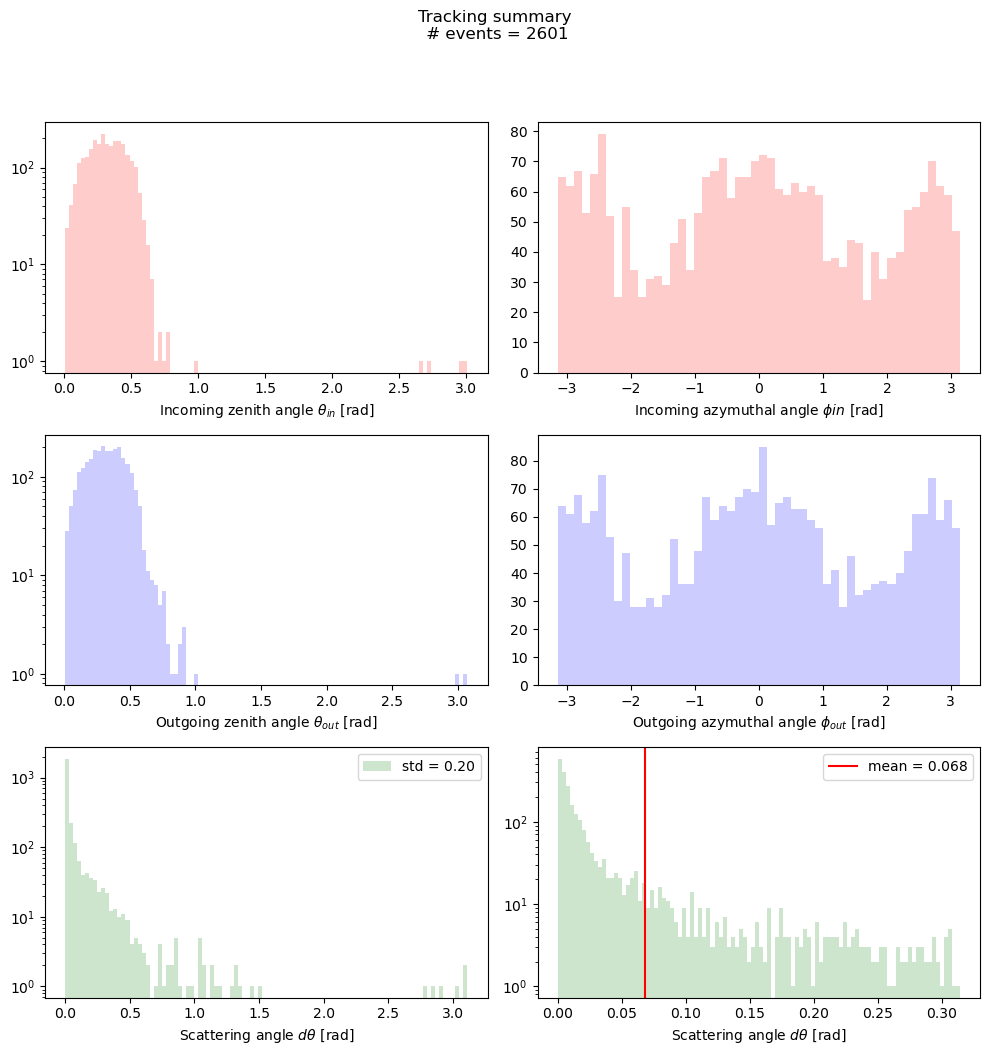

In [5]:
# Compute your mask
mask = compute_parallel_tracks_mask(tracks=tracks)

# plot tracking summary BEFORE applying cut
from copy import deepcopy
all_tracks = deepcopy(tracks)
all_tracks.plot_tracking_summary()

# Apply mask
tracks.apply_mask(mask)

# plot tracking summary AFTER applying cut
tracks.plot_tracking_summary()

## <center> **Exercice 2: POCA points computation**

Now that we got rid of parallel events, we can compute the POCA points. The function `compute_poca_points` in the `reconstruction/poca.py` file computes the POCA point from the incoming and outgoing tracks. It takes as **input**:
    
- `track_in:np.ndarray`, incoming reconstructed track, with size (3,Nevent)
- `track_out:np.ndarray`, outgoing reconstructed track, with size (3,Nevent)
- `point_in:np.ndarray`, a point on V1, with size (3,Nevent)
- `point_out:np.ndarray`, a point on V2, with size (3,Nevent)
    
and **returns**:

 - `POCA_points:np.ndarray`,  with size (3,Nevent)

In [6]:
def compute_poca_points(self,
                        track_in:np.ndarray,
                        track_out:np.ndarray,
                        point_in:np.ndarray,
                        point_out:np.ndarray,) -> np.ndarray:
    '''
    INPUT: 

    - track_in:np.ndarray, incoming reconstructed track, with size (3,Nevent)
    - track_out:np.ndarray, outgoing reconstructed track, with size (3,Nevent)
    - point_in:np.ndarray, a point on V1, with size (3,Nevent)
    - point_out:np.ndarray, a point on V2, with size (3,Nevent)

    OUTPUT: 
    - POCA_points:np.ndarray,  with size (3,Nevent)

    Given 2 lines V1, V2 aka incoming and outgoing tracks with parametric equation:
    L1 = P1 + t*V1

    1- A segment of shortest length between two 3D lines L1 L2 is perpendicular to both lines 
    (if L1 L2 are neither parallele or in the same plane). One must compute V3, vector perpendicular 
    to L1 and L2

    2- Search for points where L3 = P1 + t1*V1 +t3*V3 crosses L2. One must find t1 and t2 for which:
    L3 = P1 + t1*V1 +t3*V3 = P2 + t2*V2

    3- Then POCA location M is the middle of the segment Q1-Q2 where Q1,2 = P1,2 +t1,2*V1,2

    '''

    P1, P2 = np.transpose(point_in), np.transpose(point_out)
    V1, V2 = np.transpose(track_in), np.transpose(track_out)
    V3 = np.cross(V2,V1)

    RES = P2 - P1
    LES = np.transpose(np.stack([V1,-V2,V3]),(1,2,0))

    ts = np.linalg.solve(LES,RES)

    t1 = np.stack([ts[:,0],ts[:,0],ts[:,0]],-1)
    t2 = np.stack([ts[:,1],ts[:,1],ts[:,1]],-1)

    Q1s,Q2s = P1+t1*V1, P2+t2*V2
    M = (Q2s-Q1s)/2+Q1s

    return M

## <center> **Exercice 3: Using the POCA class**
    
Just like we did for out tracking algorithm, we can embed all of our function in the POCA class. I will make our life easier and bla, bla, bla...
    
Instanciating the POCA class requires a single input: a instance of the tracking class.

In [7]:
# importing the POCA module
from reconstruction.poca import POCA

# Run tracking 
tracks = Tracking(hits=hits[:,:,:100000])

# defining the volume to scan
from volume.volume import VolumeInterest
voi = VolumeInterest(position = [0,0,-835],
                     dimension=[600,1000,300],
                     voxel_width=10)

# Instanciating the POCA class
poca = POCA(tracks,voi)

Tracking in progress...


Tracking completed!
Scattering location computation in progress ...


Scattering location computation done


The **POCA class** has the following **attributes**:
 - `all_tracks:Tracking` The tracks received as input (contains ALL events)

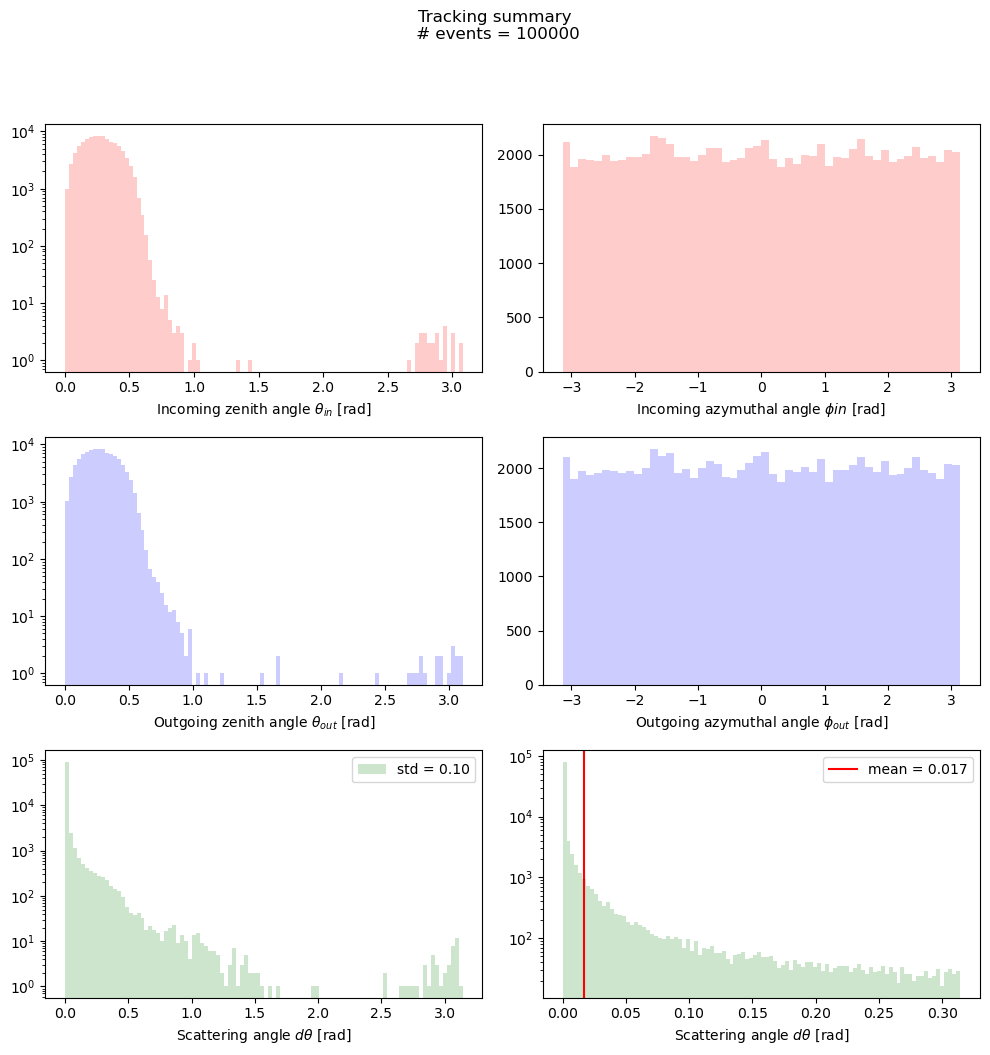

(<tracking.tracking.Tracking at 0x7efd1e518970>, None)

In [8]:
poca.all_tracks, poca.all_tracks.plot_tracking_summary()

 - `parallele_mask`: The mask used to remove parallele events

In [9]:
poca.parallel_tracks_mask, len(poca.parallel_tracks_mask)

(array([False,  True, False, ..., False, False,  True]), 100000)

 - `tracks`: The tracks after applying the mask (a.k.a after removing all parallel events)


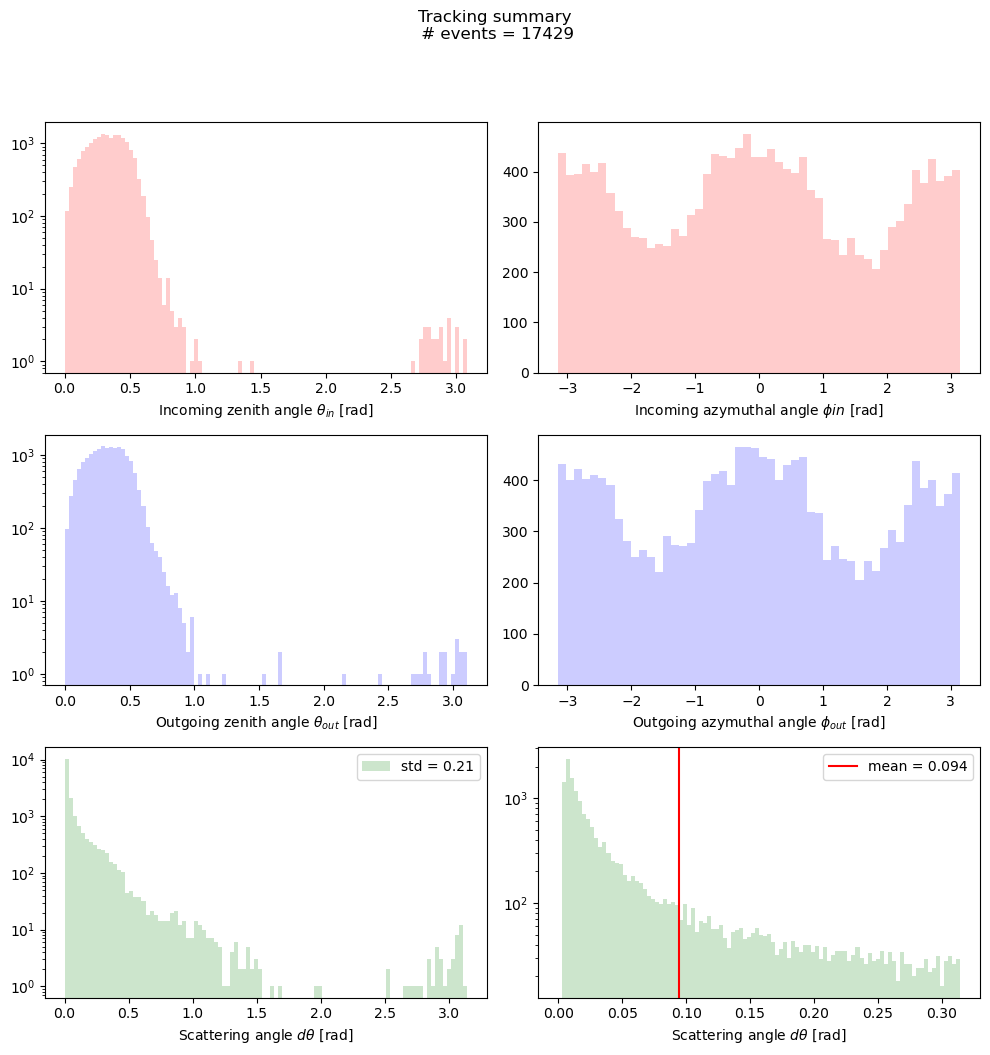

In [10]:
poca.tracks.plot_tracking_summary()

 - `poca_points:np.ndarray`: The POCA points computed using `tracks` (and NOT `all_tracks`), with shape (n_event, 3)

In [11]:
print("poca.poca_points have shape {}".format(poca.poca_points.shape))
event = np.random.randint(poca.tracks.n_event)
print("Event {} poca point is located at x,y,z = {:.1f}, {:.1f}, {:.1f}".format(event,
                                                                            poca.poca_points[event,0],
                                                                            poca.poca_points[event,1],
                                                                            poca.poca_points[event,2]))

poca.poca_points have shape (17429, 3)
Event 12383 poca point is located at x,y,z = -54.2, -159.8, -828.5


## <center> **Plotting POCA points**

### Event-wise
    
We can now have a look at our poca points method. We can use the method from plotting.plotting to visualize the poca point location. We will plot two 2D projection: one in the XZ plane and another in the YZ plane.

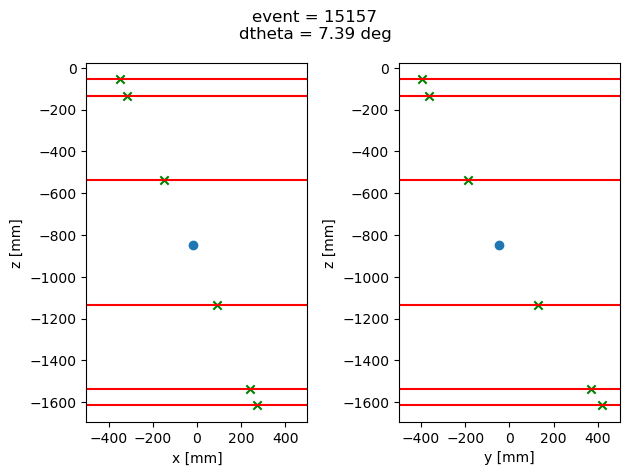

In [12]:
import math
from plotting.plotting import plot_POCA_event
mask = (tracks.dtheta*180/math.pi>5) & (tracks.dtheta*180/math.pi<8)
event = mask.nonzero()[0][np.random.randint(len(mask.nonzero()[0]))]
%matplotlib inline
plot_POCA_event(poca,event)

### 2D histogram

The `plot_POCA_points_multi_projection()` method allow us to plot the POCA point of all muons of the `POCA` class. It requires as **input**:

 - `poca_points:np.ndarray`, the array containing the poca points, with shape (n_event,3).
 - `mask:np.ndarray`, an optional mask used to filter events, with shape (n_event).
 - `binning_xyz:Tuple[int]`, number of bin along x,y,z of the histograms.
 - `filename:str`, name of the output figure.

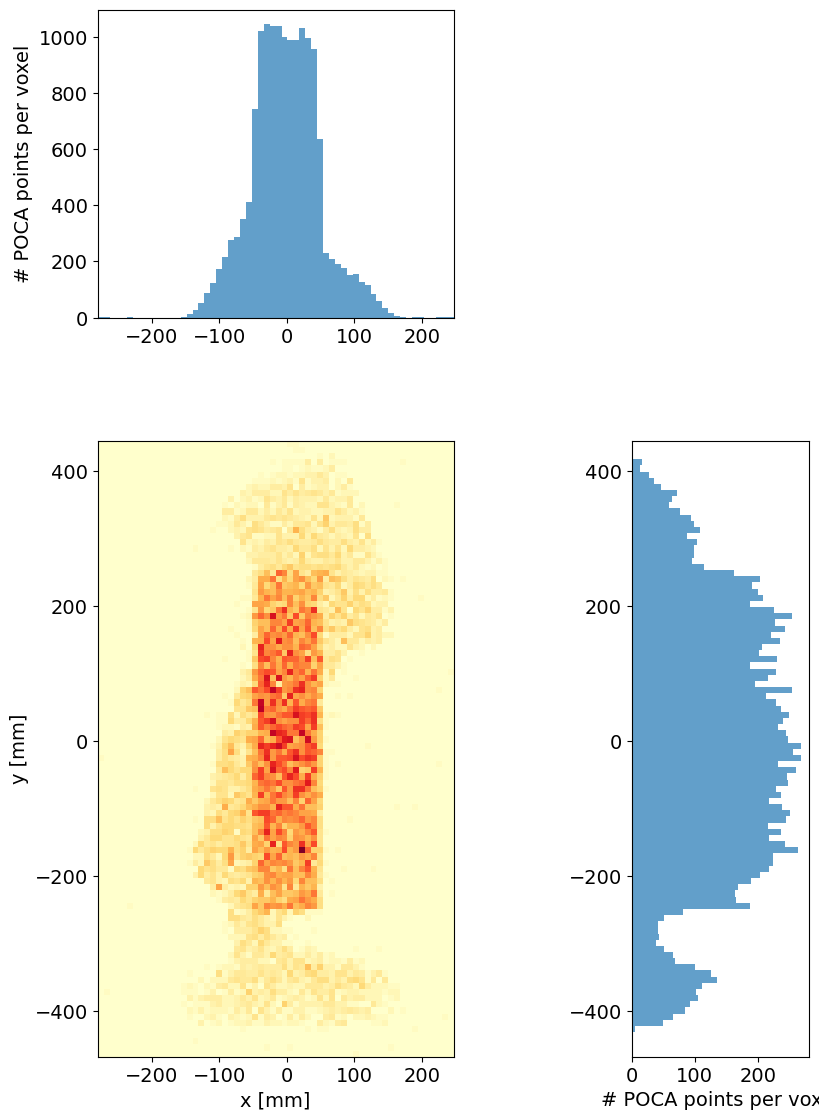

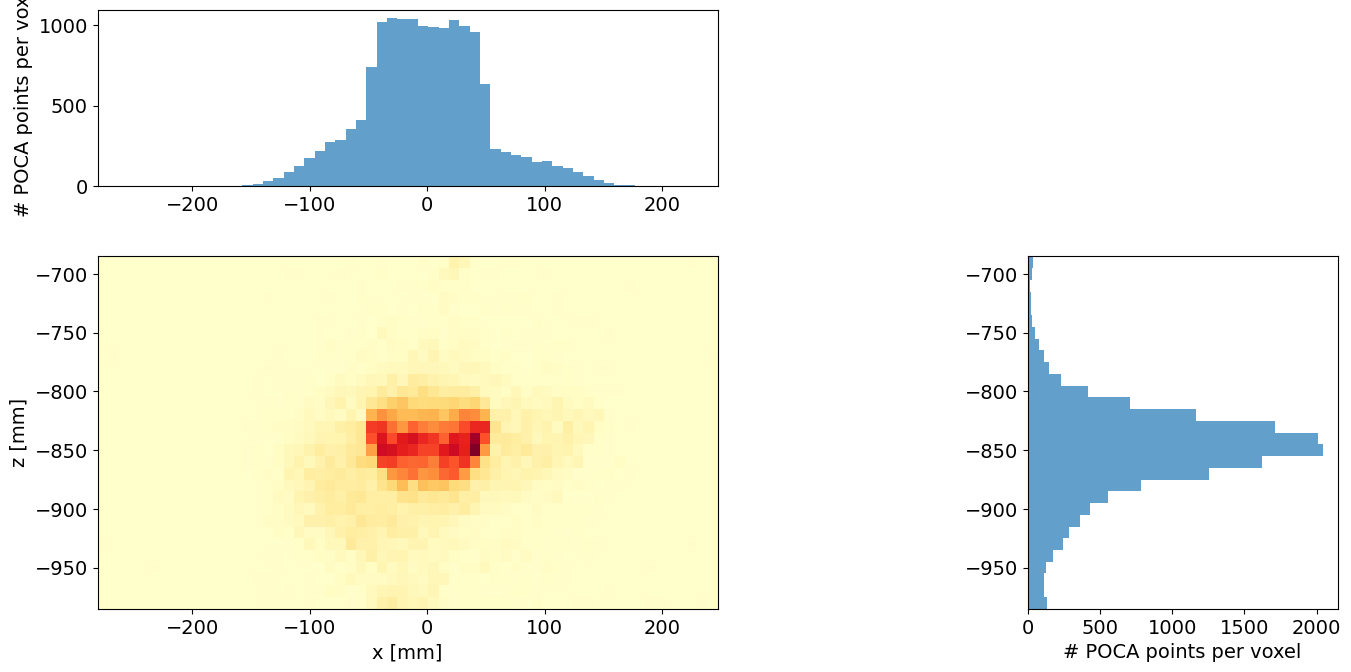

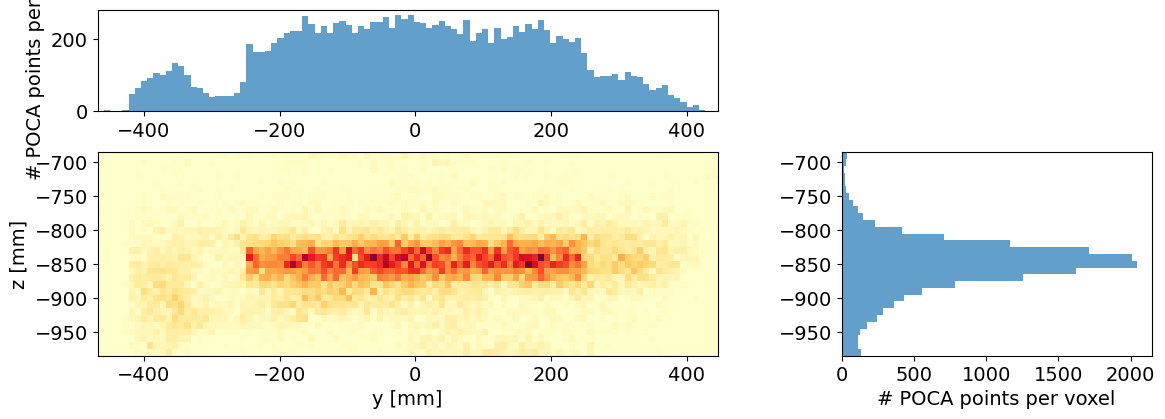

In [13]:
%matplotlib inline
from plotting.plotting import plot_POCA_points_multi_projection
plot_POCA_points_multi_projection(poca.poca_points,
                                  poca.mask_in_voi,
                                  binning_xyz=voi.n_vox_xyz,
                                  filename="TEST")

### 3D point cloud

The `plot_poca_3D_cloud()` method plot the POCA points as a 3D point cloud. It takes as **input**:
 - `poca:POCA`, an instance of the POCA class
 - `mask:Optional[np.ndarray]`, an optional mask for event selection, with size (n_event)
 - `alpha:float`, transparency between 0 and 1.
 - `color:Optional[np.ndarray]`, an optional array for color. A color will be assigned to each point i based on the value of color[i].

In [14]:
%matplotlib qt
import math
# select events with dtheta >3 deg
mask_high_scat = poca.mask_in_voi & (poca.tracks.dtheta*180/math.pi>1)
# plot 3d point cloud
from plotting.plotting import plot_poca_3D_cloud
plot_poca_3D_cloud(poca,mask_high_scat,alpha=.01,color=poca.tracks.dtheta[mask_high_scat])

In [15]:
%matplotlib qt
# select events with dtheta <1 deg
mask_low_scat = poca.mask_in_voi & (poca.tracks.dtheta*180/math.pi<1)
# plot 3d point cloud
from plotting.plotting import plot_poca_3D_cloud
plot_poca_3D_cloud(poca,mask_low_scat,alpha=.01,color=poca.tracks.dtheta[mask_low_scat])

# <center> Now Have fun!

Now that you know the basic functionnalities of the tracking and poca class, you can play with the dtheta cuts and see how it affects the reconstructed image. 

### Questions:
 - What does the density of POCA points tells you about the object's density?
     - The density of POCA points reflects the density of the material. The more POCA points, the denser the object is.
 - How many materials do you think the statue is made of? 
     - We notice a denser region a the center of the statue, shaped as a cylinder. The statue is made of at least 2 materials.
 - Qualitatively, what should be the optimal value of the dtheta cut? Why?
     - The appropriate value of dtheta cut should reject as much background poca points as possible. Usually, two cuts are applied. One to remove the parallel tracks (muons who didn't got scattered) which act as noise, and another one to remove high scattering angles events (above 10 deg) which can correspond to non muon events.